<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Project/autoencoder_for_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

### 1. Load the MNIST dataset

In [93]:
# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),    # Convert PIL image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the tensor with mean and standard deviation of MNIST dataset
])

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

plotting the dataset

In [ ]:
# def plot_images(images, labels, captions, rows=2, cols=4):
#     fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
#     for i, ax in enumerate(axes.flat):
#         ax.imshow(images[i], cmap='gray')
#         ax.set_title(captions[i])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Get some sample images and labels from the dataset
# sample_images = [train_dataset[i][0].squeeze().numpy() for i in range(8)]
# sample_labels = [train_dataset[i][1] for i in range(8)]
# sample_captions = [f"Label: {label}" for label in sample_labels]

# # Plot the sample images with captions
# plot_images(sample_images, sample_labels, sample_captions)

### 2. Create the Dataloaders

In [94]:
# Define the sizes for train, validation, and test sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
test_size = len(test_dataset)

In [95]:
# Split the dataset into train, validation, sets
trn_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [96]:
# Define batch size for data loaders
batch_size = 64

In [97]:
# Create data loaders for train, validation, and test sets
train_loader = DataLoader(trn_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 3. Autoencoder model

In [98]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         # Encoder layers
#         self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
#         self.encoder_maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1)
#         self.encoder_maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.encoder_linear = nn.Linear(12* 7 * 7, 64*6)

#         # Decoder layers
#         self.decoder_linear = nn.Linear(64*6, 12 * 7 * 7)
#         self.decoder_conv1 = nn.ConvTranspose2d(12, 6, kernel_size=3, stride=1, padding=1)
#         self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
#         self.decoder_conv2 = nn.ConvTranspose2d(6, 1, kernel_size=3, stride=1, padding=1)
#         self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
#         # self.decoder_sigmoid = nn.Sigmoid()

#     def encoder(self, x):
#         # Encoder
#         x = self.encoder_conv1(x)
#         x = self.encoder_maxpool1(x)
#         x = self.encoder_conv2(x)
#         x = self.encoder_maxpool2(x)
#         x = x.view(-1, 12 * 7 * 7)
#         x = self.encoder_linear(x)
#         return x

#     def decoder(self, x):
#         # Decoder
#         x = self.decoder_linear(x)
#         x = x.view(-1, 12, 7, 7)
#         x = self.decoder_conv1(x)
#         x = self.decoder_upsample1(x)
#         x = self.decoder_conv2(x)
#         x = self.decoder_upsample2(x)
#         # x = self.decoder_sigmoid(x)
#         return x

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded


In [104]:
class Autoencoder_simpler(nn.Module):
    def __init__(self):
        super(Autoencoder_simpler, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_linear = nn.Linear(12 * 7 * 7, 20)# 64*6 ---> 20

        # Decoder layers
        self.decoder_linear = nn.Linear(20, 12 * 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(12, 6, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling
        self.decoder_conv2 = nn.ConvTranspose2d(6, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling

    def encoder(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = torch.relu(x)
        x = self.encoder_conv2(x)
        x = torch.relu(x)
        x = x.view(-1, 12 * 7 * 7)
        x = self.encoder_linear(x)
        return x

    def decoder(self, x):
        # Decoder
        x = self.decoder_linear(x)
        x = x.view(-1, 12, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.decoder_conv2(x)
        x = torch.relu(x)
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### training and validation function

In [100]:
def train_and_evaluate(autoencoder, train_loader, val_loader,
                       num_epochs=10, learning_rate=1e-3, print_epoch=10, device='cuda' if torch.cuda.is_available() else 'cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    autoencoder.to(device)  # Move model to device

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        autoencoder.train()
        for images, _ in train_loader:
            images = images.to(device)  # Move data to device
            optimizer.zero_grad()
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        autoencoder.eval()
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)  # Move data to device
                outputs = autoencoder(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()

        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print losses
        if (epoch + 1) % print_epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}")

    return train_losses, val_losses

In [101]:
# Specify the device you want to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [102]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(7, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

In [103]:
def test_model_ae(autoencoder, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    autoencoder.eval()
    criterion = nn.MSELoss()

    # Get a batch of test images
    images, _ = next(iter(test_loader))
    images = images.to(device)

    # Reconstruct images using the autoencoder
    with torch.no_grad():
        reconstructed_images = autoencoder(images)

    # Move data back to CPU for plotting
    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

Training and Testing AE model

In [2]:
# instantiate the model
# autoencoder=Autoencoder()

# # train
# train_losses, val_losses = train_and_evaluate(autoencoder,
#                                               train_loader, val_loader,
#                                               num_epochs=20, print_epoch=2)

In [105]:
# instantiate the model
autoencoder_2=Autoencoder_simpler()

# train
train_losses, val_losses = train_and_evaluate(autoencoder_2,
                                              train_loader, val_loader,
                                              num_epochs=20, print_epoch=2)

Epoch [2/20], Train Loss: 0.300228832, Val Loss: 0.291599924
Epoch [4/20], Train Loss: 0.279929214, Val Loss: 0.277589674
Epoch [6/20], Train Loss: 0.271407195, Val Loss: 0.269749713
Epoch [8/20], Train Loss: 0.266290568, Val Loss: 0.265360670
Epoch [10/20], Train Loss: 0.262958380, Val Loss: 0.262874678
Epoch [12/20], Train Loss: 0.260341890, Val Loss: 0.260018305
Epoch [14/20], Train Loss: 0.258404252, Val Loss: 0.258581149
Epoch [16/20], Train Loss: 0.256682541, Val Loss: 0.256924306
Epoch [18/20], Train Loss: 0.255162348, Val Loss: 0.255575733
Epoch [20/20], Train Loss: 0.253864458, Val Loss: 0.253898860


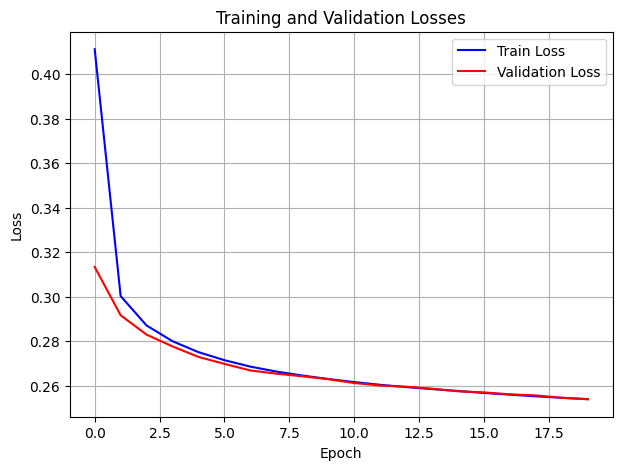

In [106]:
# Usage example:
plot_losses(train_losses, val_losses)

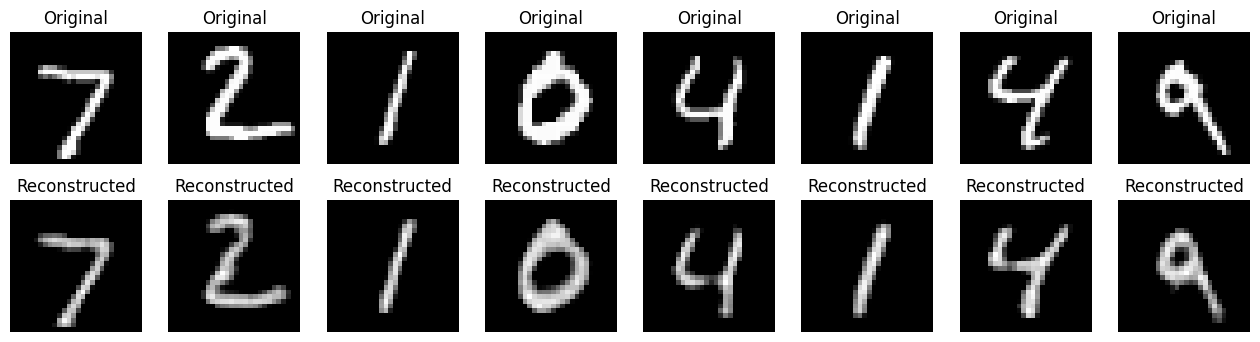

In [108]:
test_model_ae(autoencoder_2, test_loader)

### Latest conclusion:

Simpler model (`autoencoder_2`) is better than the first model (`autoencoder_1`).

### Tasks to do:

1. FOR SIMPLE MNIST DATASET
    
    ~1.a. try a few more autoencoder models and find out even more good/simple model.~

    ~1.b. Implement the VAE.~

2. FOR COLOURED MNIST DATASET

    2.a. Implement the autoencoder.
  
    2.b. Implement hte VAE

### Variational Autoencoder:

In [109]:
class VAE_SIMPLE(nn.Module):
    def __init__(self, latent_dim=8):
        super(VAE_SIMPLE, self).__init__()

        self.latent_dim = latent_dim  # Define latent_dim as an attribute of the class
        print("latent dim:", latent_dim)

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1)
        self.encoder_linear_mean = nn.Linear(16 * 7 * 7, latent_dim)  # Mean
        self.encoder_linear_logvar = nn.Linear(16 * 7 * 7, latent_dim)  # Log variance

        # Decoder layers
        self.decoder_linear = nn.Linear(latent_dim, 16 * 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(16, 8, kernel_size=4,
                                                stride=2, padding=1, output_padding=0)
        self.decoder_conv2 = nn.ConvTranspose2d(8, 1, kernel_size=4,
                                                stride=2, padding=1, output_padding=0)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = torch.relu(x)
        x = self.encoder_conv2(x)
        x = torch.relu(x)
        x = x.view(-1, 16 * 7 * 7)
        mu = self.encoder_linear_mean(x)
        logvar = self.encoder_linear_logvar(x)
        z = self.reparameterize(mu, logvar)

        # Decoder
        x = self.decoder_linear(z)
        x = x.view(-1, 16, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.decoder_conv2(x)

        return x, mu, logvar

    def generate(self, z):
        # Decoder for generating samples
        x = self.decoder_linear(z)
        x = x.view(-1, 16, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.decoder_conv2(x)

        return x

    def kl_loss(self, mu, logvar):
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return kl_loss


In [110]:
###number of parameters:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create an instance of VAE_SIMPLE
model = VAE_SIMPLE()

# Count the number of trainable parameters
num_params = count_parameters(model)
print("Number of trainable parameters:", num_params)


latent dim: 8
Number of trainable parameters: 24001


In [111]:
import torch.nn.functional as F

class VAE_FC(nn.Module):
    def __init__(self, input_dim=784, latent_dim=8, dropout_prob=0.2):
        super(VAE_FC, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout_prob = dropout_prob

        # Encoder layers
        self.encoder_fc1 = nn.Linear(input_dim, 512)
        self.encoder_dropout1 = nn.Dropout(p=dropout_prob)
        self.encoder_fc2_mean = nn.Linear(512, latent_dim)  # Mean
        self.encoder_fc2_logvar = nn.Linear(512, latent_dim)  # Log variance

        # Decoder layers
        self.decoder_fc1 = nn.Linear(latent_dim, 512)
        self.decoder_dropout1 = nn.Dropout(p=dropout_prob)
        self.decoder_fc2 = nn.Linear(512, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = torch.relu(self.encoder_fc1(x))
        x = self.encoder_dropout1(x)
        mu = self.encoder_fc2_mean(x)
        logvar = self.encoder_fc2_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = torch.relu(self.decoder_fc1(z))
        z = self.decoder_dropout1(z)
        recon_x = self.decoder_fc2(z) #torch.sigmoid(self.decoder_fc2(z))
        return recon_x.view(-1,1,28,28)

    def forward(self, x):
        # Flatten input
        x = x.view(-1, self.input_dim)
        # Encode
        mu, logvar = self.encode(x)
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        # Decode
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def kl_loss(self, mu, logvar):
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return kl_loss

    def generate(self, z):
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():
            # Decode latent vectors to generate images
            generated_images = self.decode(z).cpu()

            return generated_images

In [112]:
# Create an instance of VAE_SIMPLE
model_vae_fc = VAE_FC()

# Count the number of trainable parameters
num_params = count_parameters(model_vae_fc)
print("Number of trainable parameters:", num_params)

Number of trainable parameters: 816928


In [113]:
def train_and_evaluate_vae(vae, train_loader, val_loader,
                           num_epochs=10, learning_rate=1e-3, print_epoch=10,
                           wt_kl=0.00005,
                           device='cuda' if torch.cuda.is_available() else 'cpu'):


    criterion = nn.MSELoss()
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate
                           ,weight_decay=1e-5)

    vae.to(device)  # Move model to device

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        vae.train()
        for images, _ in train_loader:
            images = images.to(device)  # Move data to device
            optimizer.zero_grad()
            recon_images, mu, logvar = vae(images)
            recon_loss = criterion(recon_images, images)
            kl_loss = vae.kl_loss(mu, logvar)
            loss = recon_loss + wt_kl*kl_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        vae.eval()
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)  # Move data to device
                recon_images, mu, logvar = vae(images)
                recon_loss = criterion(recon_images, images)
                kl_loss = vae.kl_loss(mu, logvar)
                loss = recon_loss +  wt_kl*kl_loss
                val_loss += loss.item()

        # Average losses
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print losses
        if (epoch + 1) % print_epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}")

    return train_losses, val_losses


In [114]:
def test_model_vae(vae, test_loader,
                   device='cuda' if torch.cuda.is_available() else 'cpu'):
    vae.eval()
    criterion = nn.MSELoss(reduction = 'sum')

    # Get a batch of test images
    images, _ = next(iter(test_loader))
    images = images.to(device)

    # Reconstruct images using the VAE
    with torch.no_grad():
        reconstructed_images, _, _ = vae(images)

    # Move data back to CPU for plotting
    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

In [115]:
def plot_generated_images_vae(vae, num_samples=10,
                              device='cuda' if torch.cuda.is_available() else 'cpu'):
    vae.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # # Generate samples from the latent space
        z = torch.randn(num_samples, vae.latent_dim).to(device)
        generated_images = vae.generate(z).cpu()

        # Plot generated images
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            axes[i].imshow(generated_images[i][0], cmap='gray')
            axes[i].axis('off')
        plt.show()

Train and Test VAE model

In [116]:
# instantiate the model
vae_simple=VAE_SIMPLE()

# train
train_losses_vae, val_losses_vae = train_and_evaluate_vae(vae_simple,
                                              train_loader, val_loader,learning_rate=2e-3,
                                              num_epochs=30, print_epoch=2)

latent dim: 8
Epoch [2/30], Train Loss: 0.005702605, Val Loss: 0.005506235
Epoch [4/30], Train Loss: 0.005194906, Val Loss: 0.005145237
Epoch [6/30], Train Loss: 0.005040969, Val Loss: 0.005034409
Epoch [8/30], Train Loss: 0.004954755, Val Loss: 0.004966163
Epoch [10/30], Train Loss: 0.004900964, Val Loss: 0.004920019
Epoch [12/30], Train Loss: 0.004864266, Val Loss: 0.004888068
Epoch [14/30], Train Loss: 0.004840716, Val Loss: 0.004853272
Epoch [16/30], Train Loss: 0.004815962, Val Loss: 0.004844483
Epoch [18/30], Train Loss: 0.004799569, Val Loss: 0.004814631
Epoch [20/30], Train Loss: 0.004783866, Val Loss: 0.004810279
Epoch [22/30], Train Loss: 0.004768408, Val Loss: 0.004787362
Epoch [24/30], Train Loss: 0.004759937, Val Loss: 0.004780534
Epoch [26/30], Train Loss: 0.004751951, Val Loss: 0.004787749
Epoch [28/30], Train Loss: 0.004741235, Val Loss: 0.004756248
Epoch [30/30], Train Loss: 0.004734132, Val Loss: 0.004751647


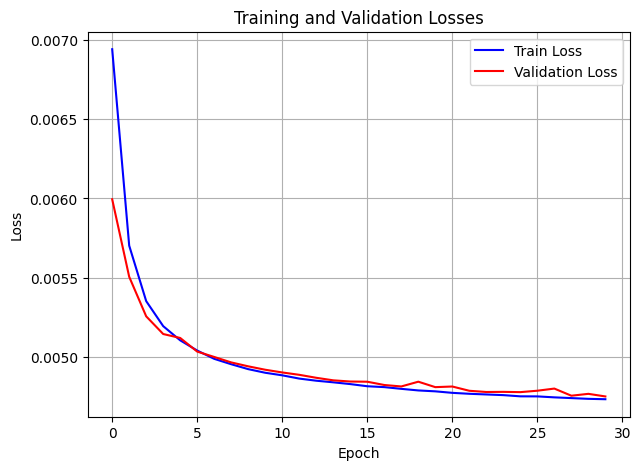

In [117]:
plot_losses(train_losses_vae[:], val_losses_vae[:])

In [129]:
# train 20 times more:
train_losses_vae, val_losses_vae = train_and_evaluate_vae(vae_simple,
                                              train_loader, val_loader,learning_rate=2e-3,
                                              num_epochs=20, print_epoch=2)

Epoch [2/20], Train Loss: 0.004728683, Val Loss: 0.004752783
Epoch [4/20], Train Loss: 0.004724432, Val Loss: 0.004752053
Epoch [6/20], Train Loss: 0.004720216, Val Loss: 0.004748221
Epoch [8/20], Train Loss: 0.004714165, Val Loss: 0.004745107
Epoch [10/20], Train Loss: 0.004710042, Val Loss: 0.004739397
Epoch [12/20], Train Loss: 0.004705080, Val Loss: 0.004730201
Epoch [14/20], Train Loss: 0.004701949, Val Loss: 0.004746110
Epoch [16/20], Train Loss: 0.004700159, Val Loss: 0.004723451
Epoch [18/20], Train Loss: 0.004698397, Val Loss: 0.004750805
Epoch [20/20], Train Loss: 0.004693524, Val Loss: 0.004735864


testing VAE fully connected model

In [118]:
# instantiate the model
vae_fc=VAE_FC()

# train
train_losses_vae_fc, val_losses_vae_fc = train_and_evaluate_vae(vae_fc,
                                              train_loader, val_loader,learning_rate=2e-3,
                                              num_epochs=30, print_epoch=2)

Epoch [2/30], Train Loss: 0.005963741, Val Loss: 0.005433323
Epoch [4/30], Train Loss: 0.005816015, Val Loss: 0.005355942
Epoch [6/30], Train Loss: 0.005759854, Val Loss: 0.005254511
Epoch [8/30], Train Loss: 0.005732512, Val Loss: 0.005353123
Epoch [10/30], Train Loss: 0.005712568, Val Loss: 0.005203713
Epoch [12/30], Train Loss: 0.005703464, Val Loss: 0.005204108
Epoch [14/30], Train Loss: 0.005692761, Val Loss: 0.005166020
Epoch [16/30], Train Loss: 0.005677622, Val Loss: 0.005201437
Epoch [18/30], Train Loss: 0.005665731, Val Loss: 0.005206403
Epoch [20/30], Train Loss: 0.005659806, Val Loss: 0.005134012
Epoch [22/30], Train Loss: 0.005656427, Val Loss: 0.005130304
Epoch [24/30], Train Loss: 0.005652473, Val Loss: 0.005216320
Epoch [26/30], Train Loss: 0.005650757, Val Loss: 0.005169329
Epoch [28/30], Train Loss: 0.005645917, Val Loss: 0.005196400
Epoch [30/30], Train Loss: 0.005651277, Val Loss: 0.005147769


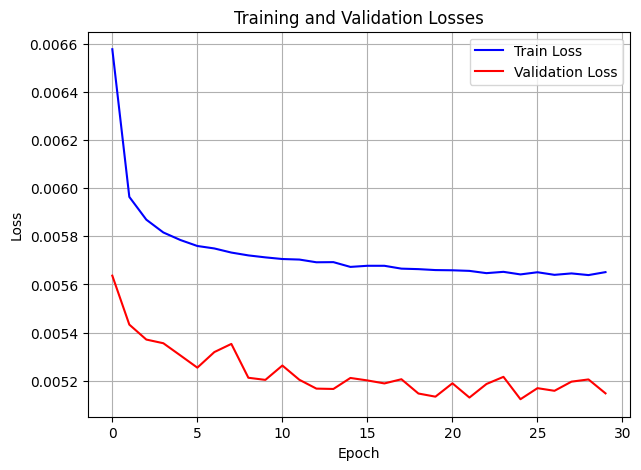

In [119]:
plot_losses(train_losses_vae_fc[:], val_losses_vae_fc[:])

In [130]:
# train 20 times more
train_losses_vae_fc, val_losses_vae_fc = train_and_evaluate_vae(vae_fc,
                                              train_loader, val_loader,learning_rate=2e-3,
                                              num_epochs=20, print_epoch=2)

Epoch [2/20], Train Loss: 0.005630056, Val Loss: 0.005188383
Epoch [4/20], Train Loss: 0.005629837, Val Loss: 0.005160476
Epoch [6/20], Train Loss: 0.005629560, Val Loss: 0.005197528
Epoch [8/20], Train Loss: 0.005631286, Val Loss: 0.005180762
Epoch [10/20], Train Loss: 0.005623669, Val Loss: 0.005211868
Epoch [12/20], Train Loss: 0.005625898, Val Loss: 0.005110156
Epoch [14/20], Train Loss: 0.005621307, Val Loss: 0.005123988
Epoch [16/20], Train Loss: 0.005623143, Val Loss: 0.005186952
Epoch [18/20], Train Loss: 0.005624102, Val Loss: 0.005156201
Epoch [20/20], Train Loss: 0.005619519, Val Loss: 0.005116890


reconstruction using VAE

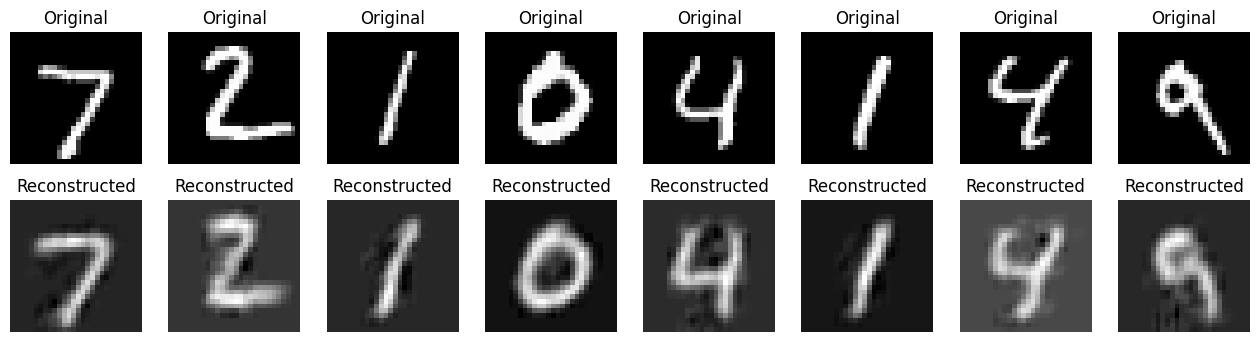

In [131]:
test_model_vae(vae_simple, test_loader)

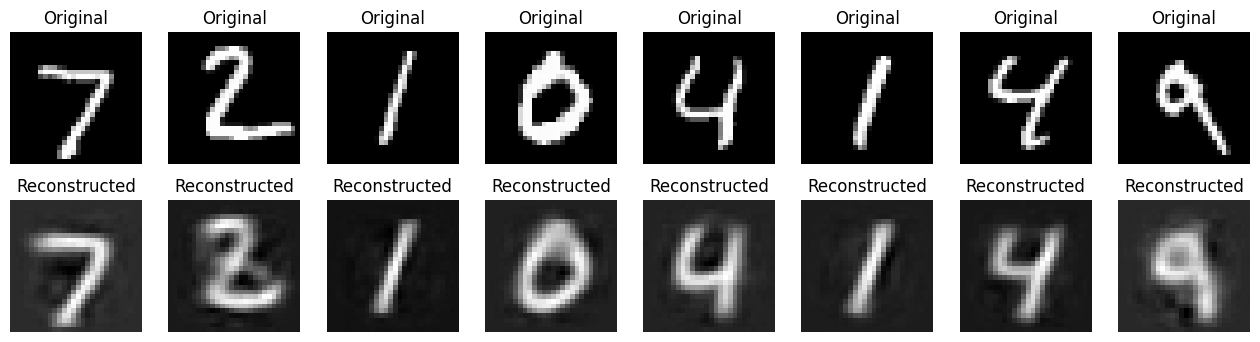

In [132]:
# testing vae with FC
test_model_vae(vae_fc, test_loader)

generating images using VAE

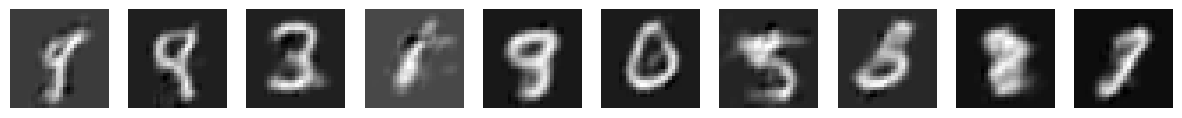

In [133]:
plot_generated_images_vae(vae_simple)

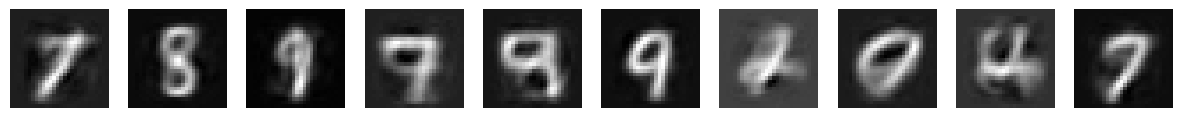

In [137]:
# testing quality of generated images with vae_fc
plot_generated_images_vae(vae_fc)

# checking something.



In [124]:
# import torch
# import torch.nn as nn
# from torchvision.datasets import MNIST
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         # Encoder layers
#         self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
#         self.encoder_maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1)
#         self.encoder_maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.encoder_linear = nn.Linear(32 * 7 * 7, 64)

#         # Decoder layers
#         self.decoder_linear = nn.Linear(64, 32 * 7 * 7)
#         self.decoder_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)
#         self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
#         self.decoder_conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1)
#         self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
#         self.decoder_sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # Encoder
#         print("image shape at the beginning:", x.shape)
#         x = self.encoder_conv1(x)
#         print("Shape after encoder_conv1:", x.shape)
#         x = self.encoder_maxpool1(x)
#         print("Shape after encoder_maxpool1:", x.shape)
#         x = self.encoder_conv2(x)
#         print("Shape after encoder_conv2:", x.shape)
#         x = self.encoder_maxpool2(x)
#         print("Shape after encoder_maxpool2:", x.shape)
#         x = x.view(-1, 32 * 7 * 7)
#         print("Shape after flattening:", x.shape)
#         x = self.encoder_linear(x)
#         print("Shape after encoder_linear:", x.shape)

#         print("encoder finished now decoder")

#         # Decoder
#         x = self.decoder_linear(x)
#         print("Shape after decoder_linear:", x.shape)
#         x = x.view(-1, 32, 7, 7)
#         print("Shape after reshaping:", x.shape)
#         x = self.decoder_conv1(x)
#         print("Shape after decoder_conv1:", x.shape)
#         x = self.decoder_upsample1(x)
#         print("Shape after decoder_upsample1:", x.shape)
#         x = self.decoder_conv2(x)
#         print("Shape after decoder_conv2:", x.shape)
#         x = self.decoder_upsample2(x)
#         print("Shape after decoder_upsample2:", x.shape)

#         return x

# # Load MNIST dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Create an instance of the autoencoder
# autoencoder = Autoencoder()

# # Take one image from the dataset
# x, _ = next(iter(train_loader))
# image = x[0].unsqueeze(0)  # Take the first image from the batch and add a batch dimension

# # Forward pass through the autoencoder with the image
# output = autoencoder(image)


In [125]:
# class VAE_SIMPLE(nn.Module):
#     def __init__(self, latent_dim=128):
#         super(VAE_SIMPLE, self).__init__()

#         self.latent_dim= latent_dim #Define latent_dim as an attribute of the class
#         print("latent dim:", latent_dim)

#         # Encoder layers
#         self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=4, stride=2, padding=1)
#         self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=4, stride=2, padding=1)
#         self.encoder_linear_mean = nn.Linear(12 * 7 * 7, latent_dim)  # Mean
#         self.encoder_linear_logvar = nn.Linear(12 * 7 * 7, latent_dim)  # Log variance

#         # Decoder layers
#         self.decoder_linear = nn.Linear(latent_dim, 12 * 7 * 7)  # Must match the output shape of the encoder_linear layers
#         self.decoder_conv1 = nn.ConvTranspose2d(12, 6, kernel_size=4,
#                                                 stride=2, padding=1, output_padding=0)  # Must match the output shape of encoder_conv2
#         self.decoder_conv2 = nn.ConvTranspose2d(6, 1, kernel_size=4,
#                                                 stride=2, padding=1, output_padding=0)  # Must match the output shape of encoder_conv1


#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         # Encoder
#         x = self.encoder_conv1(x)
#         print("After encoder_conv1:", x.shape)
#         x = torch.relu(x)
#         print("After ReLU:", x.shape)
#         x = self.encoder_conv2(x)
#         print("After encoder_conv2:", x.shape)
#         x = torch.relu(x)
#         print("After ReLU:", x.shape)
#         x = x.view(-1, 12 * 7 * 7)
#         print("After flattening:", x.shape)
#         mu = self.encoder_linear_mean(x)
#         print("Mean shape:", mu.shape)
#         logvar = self.encoder_linear_logvar(x)
#         print("Logvar shape:", logvar.shape)
#         z = self.reparameterize(mu, logvar)

#         # Decoder
#         x = self.decoder_linear(z)
#         print("After decoder_linear:", x.shape)
#         x = x.view(-1, 12, 7, 7)
#         print("After reshaping:", x.shape)
#         x = self.decoder_conv1(x)
#         print("After decoder_conv1:", x.shape)
#         x = torch.relu(x)
#         print("After ReLU:", x.shape)
#         x = self.decoder_conv2(x)
#         print("After decoder_conv2:", x.shape)
#         #x = torch.sigmoid(x)  # Use sigmoid activation for output in [0, 1]

#         return x, mu, logvar

#     def generate(self, z):

#         # Generate samples from the standard normal distribution
#         #z = torch.randn(batch_size, self.latent_dim).to(device)
#         # Decoder for generating samples
#         x = self.decoder_linear(z)
#         print("After decoder_linear:", x.shape)
#         x = x.view(-1, 12, 7, 7)
#         print("After reshaping:", x.shape)
#         x = self.decoder_conv1(x)
#         print("After decoder_conv1:", x.shape)
#         x = torch.relu(x)
#         print("After ReLU:", x.shape)
#         x = self.decoder_conv2(x)
#         print("After decoder_conv2:", x.shape)
#         #x = torch.sigmoid(x)  # Use sigmoid activation for output in [0, 1]

#         return x

#     def kl_loss(self, mu, logvar):
#         # KL divergence loss
#         kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#         return kl_loss

# # # Load MNIST dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Create an instance of the autoencoder
# vae = VAE_SIMPLE()

# # Take one image from the dataset
# x, _ = next(iter(train_loader))
# image = x[0].unsqueeze(0)  # Take the first image from the batch and add a batch dimension

# # Forward pass through the autoencoder with the image
# output = vae(image)
